In [1]:
from astropy import units as u
from astropy import time
import astropy
import numpy as np

from poliastro import iod
from poliastro.bodies import Body,Mars, Earth, Venus, Jupiter, Saturn, Uranus, Neptune, Sun, Europa, Ganymede, Callisto, Io, Titan
from poliastro.ephem import Ephem
from poliastro.maneuver import Maneuver
from poliastro.twobody import Orbit
from poliastro.util import time_range
from poliastro.frames import Planes
from poliastro.frames.fixed import JupiterFixed
from poliastro.frames.equatorial import JupiterICRS
from astroquery.jplhorizons import Horizons
from copy import deepcopy

from scipy import ndimage
from scipy.spatial.transform import Rotation as scipyRot

from poliastro.plotting import OrbitPlotter3D, StaticOrbitPlotter
import math
import matplotlib.pyplot as plt
# More info: https://plotly.com/python/renderers/
import plotly.io as pio
from poliastro.util import norm, time_range
pio.renderers.default = "plotly_mimetype+notebook_connected"
import weakref
from astropy.coordinates import solar_system_ephemeris
from collections.abc import Mapping
from libs.poliastro_util_extra import  match_astro_query_num,  get_single_burn_elliptical_hohmann ,match_orbit_plane,  search_for_resonant_orbit


solar_system_ephemeris.set("jpl")

<ScienceState solar_system_ephemeris: 'jpl'>

In [2]:
##Dates
#From general trajectory, we can arrive conservatively between june 17th 2037 & 6th august
arrival_date_first=time.Time("2037-06-17 00:01", scale="utc").tdb
arrival_date_second=time.Time("2037-06-21 00:01", scale="utc").tdb  
arrival_dates=time_range(arrival_date_first, end=arrival_date_second, periods=50)
sim_end_date = time.Time("2038-09-01 00:01", scale="utc").tdb

simulation_epoch=time_range(start=arrival_date_first,end=sim_end_date,periods=50)


io_ephem = Ephem.from_horizons(501,epochs= simulation_epoch, attractor= Jupiter, plane=Planes.EARTH_ECLIPTIC)#Io is 501
ganymede_ephem = Ephem.from_horizons(503,epochs= simulation_epoch, attractor= Jupiter, plane=Planes.EARTH_ECLIPTIC)#Ganymede is 503
europa_ephem = Ephem.from_horizons(502,epochs= simulation_epoch, attractor= Jupiter, plane=Planes.EARTH_ECLIPTIC)#Europa is 502
callisto_ephem = Ephem.from_horizons(504,epochs= simulation_epoch, attractor= Jupiter, plane=Planes.EARTH_ECLIPTIC) 


##Orbital Insertion Parameters
c3 = 550*u.km**2/u.s**2  
r_perijove = Jupiter.R+200000 * u.km
r_apijove = Jupiter.R+2e7*u.km

placeholder_io_orbit=Orbit.from_ephem(Jupiter,io_ephem,arrival_date_first)
placeholder_ganymede_orbit=Orbit.from_ephem(Jupiter,ganymede_ephem,arrival_date_first)
placeholder_callisto_orbit=Orbit.from_ephem(Jupiter,callisto_ephem,arrival_date_first)
placeholder_europa_orbit=Orbit.from_ephem(Jupiter,europa_ephem,arrival_date_first)

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "utctai" yielded 1 of "dubious year (Note 3)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"



/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/astropy/units/decorators.py:302: UserWarning:

Wrapping true anomaly to -π <= nu < π

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "utctai" yielded 1 of "dubious year (Note 3)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/astropy/units/decorators.py:302: UserWarning:

Wrapping true anomaly to -π <= nu < π

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "utct

306.7752419551946 m / s
[<Time object: scale='tdb' format='iso' value=2037-06-20 20:07:03.062>, <Quantity 62. d>, 0 x 0 AU x 2.3 deg orbit around Jupiter (♃) at epoch 2037-06-20 20:05:53.878 (UTC), Number of impulses: 2, Total cost: 13.030271 km / s]
blah
Getting ephems from 2037-10-03 18:52:43.750.


/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "taiutc" yielded 50 of "dubious year (Note 4)"



1629.4249004707733 m / s


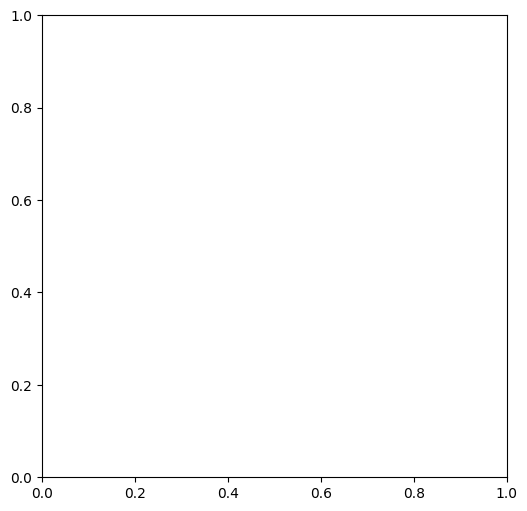

In [3]:
arrival_date=arrival_date_first
plotter=StaticOrbitPlotter(plane=Planes.EARTH_ECLIPTIC)

lowest_dv=1000*u.m/u.s
character=[]



#arrival date is date of insertion into jupiter orbit
for arrival_date in arrival_dates:   
    a_exit = (r_perijove+r_apijove)/2
    ecc_exit = (r_perijove-r_apijove)/(r_perijove+r_apijove)


    arrival_orbit = Orbit.from_classical(
        Jupiter,
        a_exit,
        ecc_exit,
        placeholder_ganymede_orbit.inc,
        placeholder_ganymede_orbit.raan,
        0 * u.deg,
        180 * u.deg,  
        time.Time(arrival_date, scale="utc"),
        plane=Planes.EARTH_ECLIPTIC
    )
    for tof in range(55,65)*u.day:
        ganymede_orb= placeholder_ganymede_orbit.propagate(arrival_date+tof)
        lambert=Maneuver.lambert(arrival_orbit,ganymede_orb,M=0)
        dv=np.linalg.norm(lambert[0][1])
        if dv<lowest_dv:
            lowest_dv=dv
            character=[arrival_date,tof,arrival_orbit,lambert]
print(lowest_dv)
print(character)
arrival_date_final=character[0]
tof_final=character[1]
print("blah")

dum1,dum2,dum3,dum4,dum5=get_single_burn_elliptical_hohmann(Jupiter,Ganymede,arrival_orbit,45*u.day,65*u.day)
print(dum1)


In [4]:
# print(dum1)

Entered into 271483 x 8831671 km x 2.3 deg orbit around Jupiter (♃) at epoch 2037-06-20 20:05:53.878 (UTC)
with perijove 199990.99951240415 km


/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "utctai" yielded 1 of "dubious year (Note 3)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "taiutc" yielded 150 of "dubious year (Note 4)"



Period of insertion orbit: 62.733389544564076 d


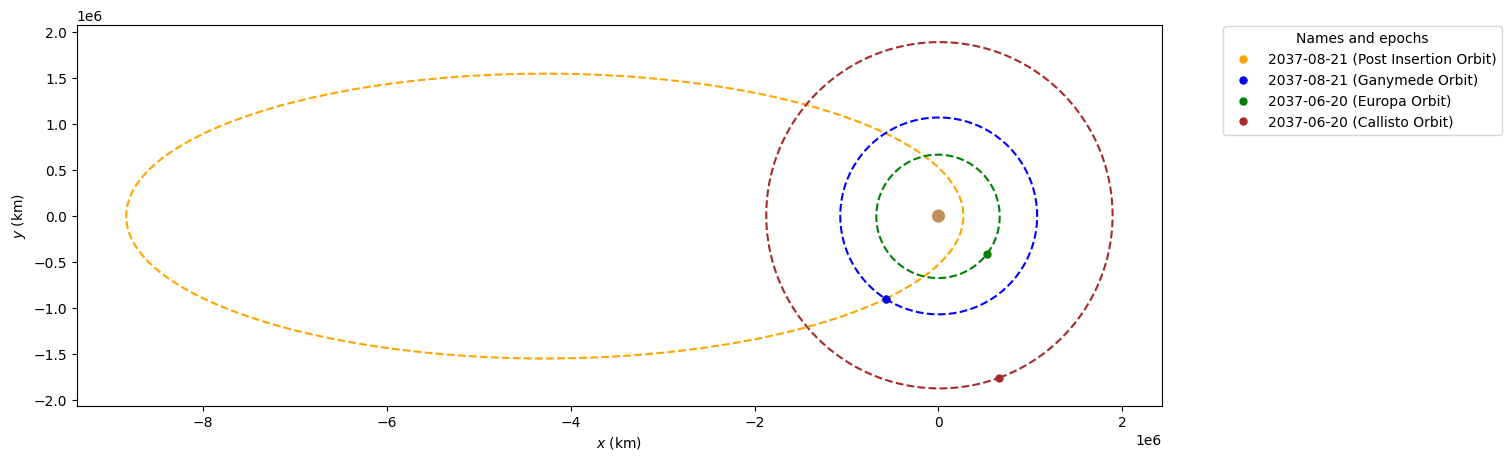

In [5]:
first_assist_date=arrival_date_final+tof_final

ganymede_orb=placeholder_ganymede_orbit.propagate(first_assist_date)
europa_orb=placeholder_europa_orbit.propagate(arrival_date_final)
callisto_orb=placeholder_callisto_orbit.propagate(arrival_date_final)

plotter=StaticOrbitPlotter(plane=Planes.EARTH_ECLIPTIC)
post_insertion_orb,dummy=character[2].apply_maneuver(character[3],intermediate=True)
print(f"Entered into {post_insertion_orb}")
print(f"with perijove {post_insertion_orb.r_p.to(u.km)-Jupiter.R.to(u.km)}")

post_insertion_orb=post_insertion_orb.propagate(first_assist_date)

plotter.plot(post_insertion_orb, label="Post Insertion Orbit", color="orange")
plotter.plot(ganymede_orb, label="Ganymede Orbit", color="blue")    
# plotter.plot(dummy, label="Transfer Maneuver", color="red")
plotter.plot(europa_orb, label="Europa Orbit", color="green")
plotter.plot(callisto_orb, label="Callisto Orbit", color="brown")
print(f"Period of insertion orbit: {post_insertion_orb.period.to(u.day)}")


Ok, so from general trajectory, we have an arrival at Ganymede on 17th August 2037 from an insertion on 17th June with ~(0.5+0.13)km/s DV. 




-find direction that slows you down relative to Jupiter
-look for orbits that are rational multiple of orbit of the moon

In [6]:
# ##find lowest possible period orbit that is still a multiple of ganymede's period, this can continue until period approaches Ganymedes
# def search_for_resonant_slingshot(body_orb, body, r_p_min, r_p_max):#take in orbit of body we are slingshotting around
#     slingshot_epoch=body_orb.epoch
#     r_ps=np.geomspace(r_p_min,r_p_max)*u.km+body.R
#     for r_p in r_ps:
#         axis = np.array([0,0,1.0])   #rotate in ecliptic plane intitially   
#         rot_ang=2*np.arcsin(1/)



In [7]:
##find lowest possible period orbit that is still a multiple of ganymede's period, this can continue until period approaches Ganymedes
def search_for_resonant_slingshot(body_orb, body, inc_orb_vel, r_p_min, r_p_max, num_samples=150, max_resonance_ratio=10):
    """
    Find the gravity assist that produces the lowest period orbit that is still a resonant multiple of the body's period.
    
    Parameters:
    body_orb: Orbit of the body we're slingshotting around
    body: The body itself (e.g., Ganymede)
    inc_orb_vel: Incoming velocity vector of spacecraft relative to Jupiter
    r_p_min, r_p_max: Min/max periapsis distances for flyby
    num_samples: Number of periapsis values to scan
    max_resonance_ratio: Maximum numerator or denominator to check (default 10)
    
    Returns:
    best_orbit: The resonant orbit with lowest period
    best_resonance: Tuple (n_sc, n_body) representing the resonance ratio
    best_rp: Periapsis distance that achieves this
    """
    
    slingshot_epoch = body_orb.epoch
    body_period = body_orb.period
    
    # Relative velocity & speed to body we are slingshotting around
    rel_vel = inc_orb_vel - body_orb.rv()[1]
    rel_speed = np.linalg.norm(rel_vel)
    
    # Sample periapsis distances
    r_ps = body.R + np.linspace(r_p_min.value, r_p_max.value, num=num_samples) * u.km
    
    # Calculate deflection angles for each periapsis
    rot_angs = 2 * np.arcsin(1 / ((r_ps * rel_speed**2 / body.k) + 1 * u.one))
    
    # Rotation axis in ecliptic plane
    axis = np.array([0, 0, 1.0])
    axis = axis / np.linalg.norm(axis)
    
    best_orbit = None
    best_resonance = None
    best_rp = None
    best_period = np.inf * u.day
    
    # Try both rotation directions (leading/trailing side flybys)
    for sign in [1]:
        for i, rot_ang in enumerate(rot_angs):
            # Rotate the relative velocity
            rot = scipyRot.from_rotvec(sign * axis * rot_ang.value)
            rel_vel_out = rot.apply(rel_vel.value) * u.km / u.s
            
            # Calculate post-assist velocity in Jupiter frame
            post_assist_vel = rel_vel_out + body_orb.rv()[1]
            
            # Create orbit from post-assist state
            test_orb = Orbit.from_vectors(
                Jupiter, 
                body_orb.r, 
                post_assist_vel, 
                slingshot_epoch,
                plane=Planes.EARTH_ECLIPTIC
            )
            
            #only consider orbits that don't crash into the planet
            if test_orb.r_p < Jupiter.R:
                continue
            
            # Only consider bound orbits
            if test_orb.ecc >= 1:
                continue
            
            # Check if orbit crosses body's orbital radius (necessary for resonance)
            body_radius = body_orb.a
            orbit_crosses = (test_orb.r_p < body_radius < test_orb.r_a)
            
            if not orbit_crosses:
                continue
            
            # Calculate the period ratio
            period_ratio = test_orb.period / body_period
            # print(period_ratio)
            # Check for integer resonances by testing simple fractions
            found_resonance = False
            for n_body in range(1, max_resonance_ratio + 1):
                for n_sc in range(1, max_resonance_ratio + 1):
                    expected_ratio = n_body / n_sc
                    ratio_error = abs(period_ratio.value - expected_ratio) / expected_ratio
                    
                    if ratio_error < 0.03 :
                        # Check if this is better than current best (lower period)
                        if test_orb.period < best_period:
                            best_period = test_orb.period
                            best_orbit = test_orb
                            best_resonance = (n_sc, n_body)
                            best_rp = r_ps[i]
                            print(f"Found {n_sc}:{n_body} resonance: period={test_orb.period.to(u.day):.2f}, r_p={r_ps[i]:.0f}")
                            found_resonance = True
                            break
                if found_resonance:
                    break
        
        if best_orbit is None:
            print("No resonant orbit found!")
            return None, None, None
        
        print(f"\nBest resonance: {best_resonance[0]}:{best_resonance[1]}")
        print(f"Period: {best_period.to(u.day):.2f} (target body: {body_period.to(u.day):.2f})")
        print(f"Periapsis: {best_rp:.0f}")
        
        return best_orbit, best_resonance, best_rp
    

GANYMEDE ENCOUNTER #1
Found 1:5 resonance: period=36.61 d, r_p=2644100 m

Best resonance: 1:5
Period: 36.61 d (target body: 7.15 d)
Periapsis: 2644100 m

=== Encounter #1 Results ===
Resonance found: 1:5
Spacecraft does 1 orbits while Ganymede does 5
Post-assist orbit period: 36.61 d, it should be close to 35.76 d
Flyby periapsis altitude: 10 km
Eccentricity: 0.926
Total delta-v to adjust orbit: 23.00 m / s

Time until next Ganymede encounter: 35.74 d
GANYMEDE ENCOUNTER #2
Found 2:7 resonance: period=24.51 d, r_p=2644100 m

Best resonance: 2:7
Period: 24.51 d (target body: 7.15 d)
Periapsis: 2644100 m

=== Encounter #2 Results ===
Resonance found: 2:7
Spacecraft does 2 orbits while Ganymede does 7
Post-assist orbit period: 24.51 d, it should be close to 25.03 d
Flyby periapsis altitude: 10 km
Eccentricity: 0.925
Total delta-v to adjust orbit: 28.00 m / s

Time until next Ganymede encounter: 50.04 d
GANYMEDE ENCOUNTER #3
Found 3:8 resonance: period=18.65 d, r_p=2644100 m

Best resonance

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "utctai" yielded 1 of "dubious year (Note 3)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "taiutc" yielded 150 of "dubious year (Note 4)"




Completed 5 gravity assists
Total ΔV for resonance corrections: 163.00 m / s
Total mission time: 271.72 d

Encounter dates:
  Encounter #1: 2037-08-21 20:07:03.062
  Encounter #2: 2037-09-26 13:46:14.000
  Encounter #3: 2037-11-15 14:50:24.957
  Encounter #4: 2038-01-11 20:08:53.641
  Encounter #5: 2038-03-17 04:53:09.468
  Next encounter (#6): 2038-05-20 13:28:20.674

Resonances achieved:
  Assist #1: 1:5 (period = 35.74 d)
  Assist #2: 2:7 (period = 25.02 d)
  Assist #3: 3:8 (period = 19.07 d)
  Assist #4: 4:9 (period = 16.09 d)
  Assist #5: 5:9 (period = 12.87 d)

Periapsis altitudes:
  Assist #1: 10 km (2644 km from center)
  Assist #2: 10 km (2644 km from center)
  Assist #3: 10 km (2644 km from center)
  Assist #4: 660 km (3294 km from center)
  Assist #5: 10 km (2644 km from center)

Delta-v per assist:
  Assist #1: 23.00 m / s
  Assist #2: 28.00 m / s
  Assist #3: 37.00 m / s
  Assist #4: 56.00 m / s
  Assist #5: 19.00 m / s


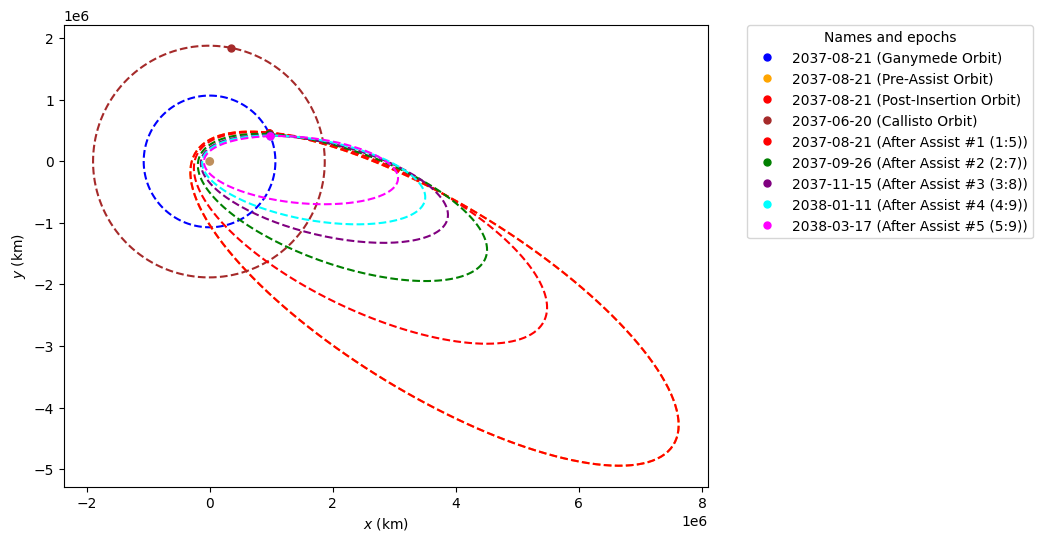

In [8]:
initial_orbit = post_insertion_orb

# Test the resonant slingshot function
r_p_min_test = 10 * u.km
r_p_max_test = 5000 * u.km

# Number of gravity assists to perform
num_assists = 5

# Storage for results
orbits_list = []
resonances_list = []
rp_list = []
dv_list = []
encounter_dates = [first_assist_date]

# Current state
current_orbit = initial_orbit
current_date = first_assist_date

# Loop through gravity assists
for assist_num in range(1, num_assists + 1):
    print("=" * 60)
    print(f"GANYMEDE ENCOUNTER #{assist_num}")
    print("=" * 60)
    
    # Get Ganymede's position at this encounter
    ganymede_orb_current = placeholder_ganymede_orbit.propagate(current_date)
    
    # Search for resonant orbit
    test_orbit, test_resonance, test_rp = search_for_resonant_orbit(
        ganymede_orb_current, 
        Ganymede, 
        current_orbit.rv()[1], 
        r_p_min_test, 
        r_p_max_test,
        num_samples=500
    )
    
    if test_orbit is None:
        print(f"No resonant orbit found for encounter #{assist_num}")
        break
    
    # Calculate required period for exact resonance
    required_resonance_time = (test_resonance[1] / test_resonance[0]) * ganymede_orb_current.period
    dif = test_orbit.period - required_resonance_time
    
    print(f"\n=== Encounter #{assist_num} Results ===")
    print(f"Resonance found: {test_resonance[0]}:{test_resonance[1]}")
    print(f"Spacecraft does {test_resonance[0]} orbits while Ganymede does {test_resonance[1]}")
    print(f"Post-assist orbit period: {test_orbit.period.to(u.day):.2f}, it should be close to {required_resonance_time.to(u.day):.2f}")
    print(f"Flyby periapsis altitude: {(test_rp - Ganymede.R).to(u.km):.0f}")
    print(f"Eccentricity: {test_orbit.ecc:.3f}")
    
    # Apply delta-v correction to achieve exact resonance
    norm_vel_vec = test_orbit.rv()[1] / np.linalg.norm(test_orbit.rv()[1])
    total_dv = 0 * u.km/u.s
    dv_adjust = 0.001 * u.km/u.s
    
    if dif < 0:
        # Need to accelerate
        orbit_is_accurate = False
        while not orbit_is_accurate:
            total_dv += dv_adjust
            delta_v = dv_adjust
            burn = delta_v * norm_vel_vec
            maneuver = Maneuver((0*u.s, burn))
            test_orbit = test_orbit.apply_maneuver(maneuver)
            dif = test_orbit.period - required_resonance_time
            if dif >= 0:
                orbit_is_accurate = True
    
    if dif > 0:
        # Need to decelerate
        orbit_is_accurate = False
        while not orbit_is_accurate:
            total_dv += dv_adjust
            delta_v = dv_adjust
            burn = -delta_v * norm_vel_vec
            maneuver = Maneuver((0*u.s, burn))
            test_orbit = test_orbit.apply_maneuver(maneuver)
            dif = test_orbit.period - required_resonance_time
            if dif <= 0:
                orbit_is_accurate = True
    
    print(f"Total delta-v to adjust orbit: {total_dv.to(u.m/u.s):.2f}")
    
    # Store results
    orbits_list.append(test_orbit)
    resonances_list.append(test_resonance)
    rp_list.append(test_rp)
    dv_list.append(total_dv)
    
    # Calculate time to next encounter
    time_to_return = test_resonance[0] * test_orbit.period
    print(f"\nTime until next Ganymede encounter: {time_to_return.to(u.day):.2f}")
    
    # Update state for next iteration
    current_date = current_date + time_to_return
    current_orbit = test_orbit.propagate(time_to_return)
    encounter_dates.append(current_date)

# Print summary
# if len(orbits_list) > 0:
# Print summary
if len(orbits_list) > 0:
    print("\n" + "=" * 60)
    print("MISSION SUMMARY")
    print("=" * 60)
    
    # Visualize all orbits
    plotter = StaticOrbitPlotter(plane=Planes.EARTH_ECLIPTIC)
    plotter.plot(ganymede_orb, label="Ganymede Orbit", color="blue")
    plotter.plot(initial_orbit, label="Pre-Assist Orbit", color="orange")
    plotter.plot(post_insertion_orb, label="Post-Insertion Orbit", color="red")
    plotter.plot(callisto_orb, label="Callisto Orbit", color="brown")
    
    colors = ["red", "green", "purple", "cyan", "magenta", "yellow", "brown", "pink"]
    for i, orbit in enumerate(orbits_list):
        color = colors[i % len(colors)]
        plotter.plot(orbit, label=f"After Assist #{i+1} ({resonances_list[i][0]}:{resonances_list[i][1]})", color=color)
    
    # Print statistics
    total_dv = sum(dv_list)
    total_time = sum([(resonances_list[i][0] * orbits_list[i].period) for i in range(len(orbits_list))])
    
    print(f"\nCompleted {len(orbits_list)} gravity assists")
    print(f"Total ΔV for resonance corrections: {total_dv.to(u.m/u.s):.2f}")
    print(f"Total mission time: {total_time.to(u.day):.2f}")
    
    print(f"\nEncounter dates:")
    for i, date in enumerate(encounter_dates[:-1]):
        print(f"  Encounter #{i+1}: {date}")
    print(f"  Next encounter (#{len(encounter_dates)}): {encounter_dates[-1]}")
    
    print(f"\nResonances achieved:")
    for i, res in enumerate(resonances_list):
        print(f"  Assist #{i+1}: {res[0]}:{res[1]} (period = {orbits_list[i].period.to(u.day):.2f})")
    
    print(f"\nPeriapsis altitudes:")
    for i, rp in enumerate(rp_list):
        altitude = (rp - Ganymede.R).to(u.km)
        print(f"  Assist #{i+1}: {altitude:.0f} ({rp.to(u.km):.0f} from center)")
    
    print(f"\nDelta-v per assist:")
    for i, dv in enumerate(dv_list):
        print(f"  Assist #{i+1}: {dv.to(u.m/u.s):.2f}")
else:
    print("No resonant orbits found - try adjusting periapsis bounds or tolerance")

In [9]:
def get_single_burn_elliptical_hohmann_test(attractor, target, initial_orb, min_tof, max_tof, tof_step=0.1*u.day):
    time_till_pe=initial_orb.period-initial_orb.t_p
    periapsis_epoch=initial_orb.epoch+time_till_pe

    sim_range=time_range(start=periapsis_epoch,end=periapsis_epoch+max_tof,periods=50)
    min_dv=10000*u.m/u.s
    final_orb=None
    final_date=None
    final_burn=None
    final_targ_orb=None
    periapsis_orb=initial_orb.propagate(periapsis_epoch)
    body_num=match_astro_query_num(target)
    body_ephem=Ephem.from_horizons(body_num,epochs=sim_range, attractor=attractor, plane=Planes.EARTH_ECLIPTIC)
    body_orb_placeholder = Orbit.from_ephem(attractor, body_ephem, periapsis_epoch)
    tof_range=np.arange(min_tof.to(u.day).value,max_tof.to(u.day).value,tof_step.to(u.day).value)*u.day
    print(f"Getting ephems from {periapsis_epoch}.")
    for i in range(len(tof_range)):
        arrival_date=periapsis_epoch+tof_range[i]
        body_orb=body_orb_placeholder.propagate(arrival_date+1*u.s)
        # print(f"{initial_orb} and {body_orb}")
        lambert=Maneuver.lambert(periapsis_orb,body_orb,M=0)
        burn=lambert[0]
        dv=np.linalg.norm(burn[1])
        if dv<min_dv:
            
            
            
            
            
            min_dv=dv
            final_orb,dummy=periapsis_orb.apply_maneuver(lambert,intermediate=True)
            final_date=arrival_date
            final_burn=burn
            final_targ_orb=body_orb
    return min_dv,final_orb,final_date,final_burn, final_targ_orb


Getting ephems from 2038-03-17 21:19:51.429.
137.05571025580346 m / s
2038-03-28 04:31:51.429


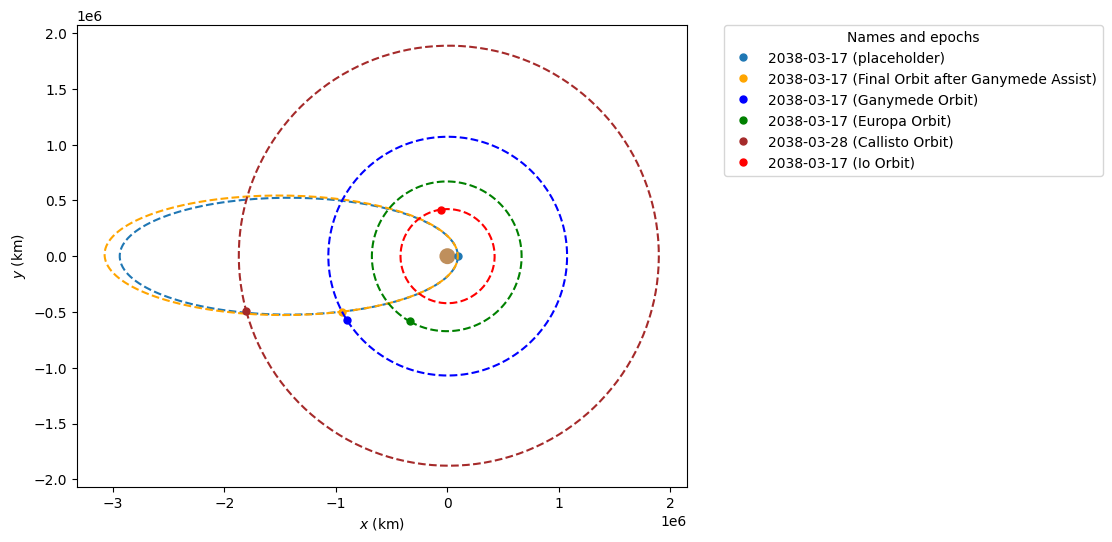

In [10]:
first_assist_set_final_orb=match_orbit_plane(orbits_list[-1],placeholder_callisto_orbit)
first_assist_set_final_date=encounter_dates[-2]
t_t_p=first_assist_set_final_orb.period.to(u.day)-first_assist_set_final_orb.t_p.to(u.day)
# print(t_p)
# print(first_assist_set_final_orb.period.to(u.day)-t_p)
dummy_orb=first_assist_set_final_orb.propagate(t_t_p)

# print(dummy_orb.nu)
# first_assist_set_final_orb.raan=placeholder_callisto_orbit.raan
# first_assist_set_final_orb.inc=placeholder_callisto_orbit.inc
# first_assist_set_final_orb.argp=placeholder_callisto_orbit.argp


io_orb=placeholder_io_orbit.propagate(first_assist_set_final_date)
europa_orb=placeholder_europa_orbit.propagate(first_assist_set_final_date)
ganymede_orb=placeholder_ganymede_orbit.propagate(first_assist_set_final_date)
callisto_orb=placeholder_callisto_orbit.propagate(first_assist_set_final_date)

plotter=StaticOrbitPlotter(plane=Planes.EARTH_ECLIPTIC)


dum1,dum2orb,dum3,dum4,dum5=get_single_burn_elliptical_hohmann_test(Jupiter,Callisto, first_assist_set_final_orb, 5*u.day, 22*u.day)
# print(first_assist_set_final_orb)
# print(dum2orb)
print(dum1)
# print(dum4)
print(dum3)



callisto_orb=placeholder_callisto_orbit.propagate(dum3)

plotter.plot(dum2orb,label="placeholder")

plotter.plot(first_assist_set_final_orb, label="Final Orbit after Ganymede Assist", color="orange")
plotter.plot(ganymede_orb, label="Ganymede Orbit", color="blue")    
plotter.plot(europa_orb, label="Europa Orbit",  color="green")
plotter.plot(callisto_orb, label="Callisto Orbit", color="brown")
plotter.plot(io_orb, label="Io Orbit", color="red")

CALLISTO GRAVITY ASSIST

Encounter date: 2038-03-28 04:31:51.429
Time from last Ganymede encounter: 10.3 d

Configuration:
  Sign: -1 (trailing side)
  Periapsis altitude: 10 km
  Periapsis distance: 2420 km
  Deflection angle: 4.16 deg deg
  Relative velocity: 8.87 km / s

Pre-assist orbit at Callisto:
  Period: 12.05 d
  Eccentricity: 0.938

Post-assist orbit:
  Period: 14.10 d
  Eccentricity: 0.923
  Periapsis: 130033 km
  Apoapsis: 3235014 km


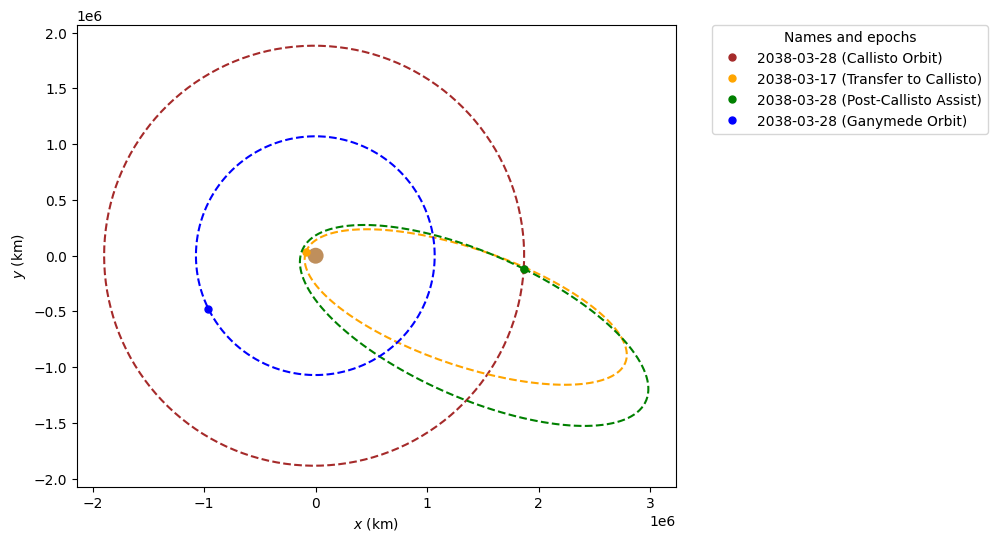

In [11]:
## Manual Gravity Assist Configuration with Callisto
# Test gravity assist with Callisto using the transfer orbit from Hohmann calculation

if len(orbits_list) > 0:
    # Use the transfer orbit to Callisto (dum2orb) and encounter date (dum3)
    # These were calculated in the previous cell
    
    # Configuration parameters
    manual_sign = -1  # 1 for leading side, -1 for trailing side
    manual_rp_altitude = 10 * u.km  # Altitude above Callisto's surface
    
    # Get spacecraft state at Callisto encounter
    transfer_orbit = dum2orb  # Transfer orbit to Callisto
    callisto_encounter_date = dum3  # Date of Callisto encounter
    
    # Get Callisto's position at the encounter
    callisto_orb_encounter = placeholder_callisto_orbit.propagate(callisto_encounter_date)
    
    # Propagate transfer orbit to encounter date
    time_to_callisto = callisto_encounter_date - transfer_orbit.epoch
    spacecraft_at_callisto = transfer_orbit.propagate(time_to_callisto)
    
    # Calculate relative velocity
    rel_vel = spacecraft_at_callisto.rv()[1] - callisto_orb_encounter.rv()[1]
    rel_speed = np.linalg.norm(rel_vel)
    
    # Calculate relative velocity
    rel_vel = spacecraft_at_callisto.rv()[1] - callisto_orb_encounter.rv()[1]
    rel_speed = np.linalg.norm(rel_vel)
    
    # Calculate periapsis distance from center
    manual_rp = Callisto.R + manual_rp_altitude
    
    # Calculate deflection angle
    manual_rot_ang = 2 * np.arcsin(1 / ((manual_rp * rel_speed**2 / Callisto.k) + 1 * u.one))
    
    # Rotation axis in ecliptic plane
    axis = np.array([0, 0, 1.0])
    axis = axis / np.linalg.norm(axis)
    
    # Apply rotation
    rot = scipyRot.from_rotvec(manual_sign * axis * manual_rot_ang.value)
    rel_vel_out = rot.apply(rel_vel.value) * u.km / u.s
    
    # Calculate post-assist velocity in Jupiter frame
    post_assist_vel = rel_vel_out + callisto_orb_encounter.rv()[1]
    
    # Create manual assist orbit
    manual_orbit = Orbit.from_vectors(
        Jupiter, 
        callisto_orb_encounter.r, 
        post_assist_vel, 
        callisto_encounter_date,
        plane=Planes.EARTH_ECLIPTIC
    )
    
    print("=" * 60)
    print("CALLISTO GRAVITY ASSIST")
    print("=" * 60)
    print(f"\nEncounter date: {callisto_encounter_date.iso}")
    print(f"Time from last Ganymede encounter: {time_to_callisto.to(u.day):.1f}")
    print(f"\nConfiguration:")
    print(f"  Sign: {manual_sign} ({'leading' if manual_sign > 0 else 'trailing'} side)")
    print(f"  Periapsis altitude: {manual_rp_altitude.to(u.km):.0f}")
    print(f"  Periapsis distance: {manual_rp.to(u.km):.0f}")
    print(f"  Deflection angle: {np.degrees(manual_rot_ang):.2f} deg")
    print(f"  Relative velocity: {rel_speed.to(u.km/u.s):.2f}")
    print(f"\nPre-assist orbit at Callisto:")
    print(f"  Period: {spacecraft_at_callisto.period.to(u.day):.2f}")
    print(f"  Eccentricity: {spacecraft_at_callisto.ecc:.3f}")
    print(f"\nPost-assist orbit:")
    print(f"  Period: {manual_orbit.period.to(u.day):.2f}")
    print(f"  Eccentricity: {manual_orbit.ecc:.3f}")
    print(f"  Periapsis: {manual_orbit.r_p.to(u.km):.0f}")
    print(f"  Apoapsis: {manual_orbit.r_a.to(u.km):.0f}")
    
    # Visualize
    plotter = StaticOrbitPlotter(plane=Planes.EARTH_ECLIPTIC)
    plotter.plot(callisto_orb_encounter, label="Callisto Orbit", color="brown")
    plotter.plot(transfer_orbit, label="Transfer to Callisto", color="orange")
    plotter.plot(manual_orbit, label=f"Post-Callisto Assist", color="green")
    
    
    # Also show Ganymede for reference
    ganymede_ref = placeholder_ganymede_orbit.propagate(callisto_encounter_date)
    plotter.plot(ganymede_ref, label="Ganymede Orbit", color="blue")
else:
    print("No resonant orbits available for manual assist")

2038-03-29 22:17:44.570
Getting ephems from 2038-03-29 22:17:44.570.

=== Io Transfer Results ===
Transfer ΔV: 306.19 m / s
Io encounter date: 2038-04-07 21:28:46.970
Transfer time: 10.7 d
-1.6373610004772745 rad


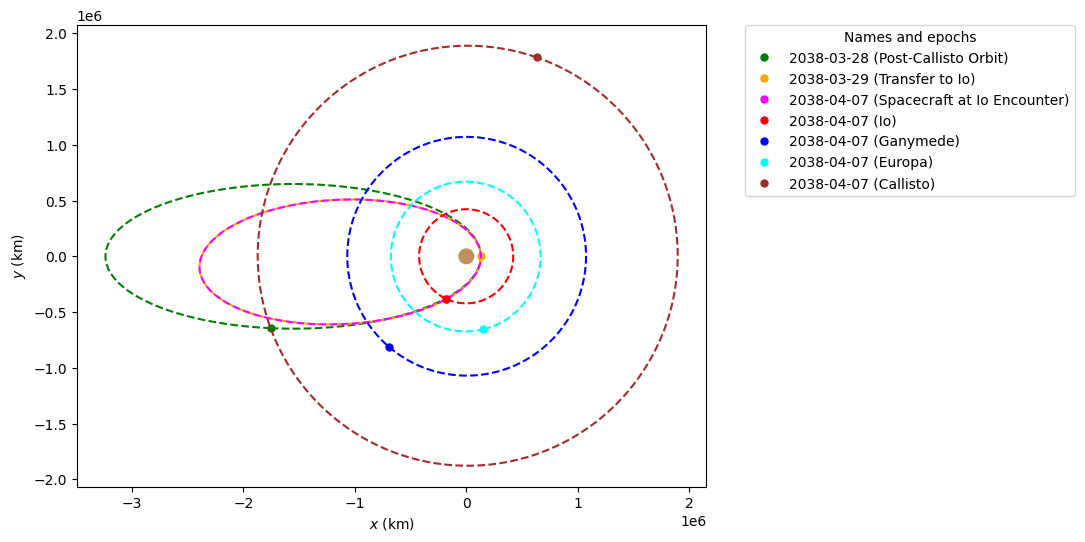

In [12]:
## Transfer to Io
# After Callisto gravity assist, find Hohmann transfer to Io
t_t_p=manual_orbit.period.to(u.day)-manual_orbit.t_p.to(u.day)
active_epochs=time_range(start=callisto_encounter_date+t_t_p,end=sim_end_date,periods=50)
print(active_epochs[0])
io_ephem_redone=Ephem.from_horizons(501,epochs= active_epochs, attractor= Jupiter, plane=Planes.EARTH_ECLIPTIC)#Io is 501
placeholder_io_orbit=Orbit.from_ephem(Jupiter,io_ephem_redone,callisto_encounter_date+t_t_p)

# Use post-Callisto orbit to find transfer to Io
post_callisto_orbit = manual_orbit
callisto_date = callisto_encounter_date

# Match plane with Io for easier transfer
coplanar_post_callisto = match_orbit_plane(post_callisto_orbit, placeholder_io_orbit)


# Search for transfer to Io (shorter TOF since Io is closer)
io_dv, io_transfer_orb, io_date, io_burn, io_dummy_orb = get_single_burn_elliptical_hohmann_test(
    Jupiter, 
    Io, 
    coplanar_post_callisto, 
    2*u.day,  # Min TOF - Io is much closer than Callisto
    9*u.day  # Max TOF
    ,tof_step=0.003*u.day
)

print(f"\n=== Io Transfer Results ===")
print(f"Transfer ΔV: {io_dv.to(u.m/u.s):.2f}")
print(f"Io encounter date: {io_date.iso}")
print(f"Transfer time: {(io_date - callisto_date).to(u.day):.1f}")
# Get Io's orbit at encounter
io_orb_encounter = placeholder_io_orbit.propagate(io_date)


# Propagate spacecraft to Io
spacecraft_at_io = io_transfer_orb.propagate(io_date)

# print(f"\nSpacecraft state at Io encounter:")
# print(f"  Period: {spacecraft_at_io.period.to(u.day):.2f}")
# print(f"  Eccentricity: {spacecraft_at_io.ecc:.3f}")
# print(f"  Periapsis: {spacecraft_at_io.r_p.to(u.km):.0f}")
# print(f"  Apoapsis: {spacecraft_at_io.r_a.to(u.km):.0f}")

# Visualize transfer to Io
plotter = StaticOrbitPlotter(plane=Planes.EARTH_ECLIPTIC)
plotter.plot(post_callisto_orbit, label="Post-Callisto Orbit", color="green")
plotter.plot(io_transfer_orb, label="Transfer to Io", color="orange")
plotter.plot(spacecraft_at_io, label="Spacecraft at Io Encounter", color="magenta")

plotter.plot(io_orb_encounter, label="Io", color="red")
# plotter.plot(io_dummy_orb,label="dummy")
# Show other moons for reference
ganymede_ref = placeholder_ganymede_orbit.propagate(io_date)
europa_ref = placeholder_europa_orbit.propagate(io_date);
callisto_ref = placeholder_callisto_orbit.propagate(io_date)
plotter.plot(ganymede_ref, label="Ganymede", color="blue")
plotter.plot(europa_ref, label="Europa", color="cyan")
plotter.plot(callisto_ref, label="Callisto", color="brown")
print(io_orb_encounter.nu)


IO ENCOUNTER #1
Found 2:9 resonance: period=7.75 d, r_p=1826600 m

Best resonance: 2:9
Period: 7.75 d (target body: 1.77 d)
Periapsis: 1826600 m

=== Io Encounter #1 Results ===
Resonance found: 2:9
Spacecraft does 2 orbits while Io does 9
Post-assist orbit period: 7.75 d, should be 7.97 d
Flyby periapsis altitude: 5 km
Eccentricity: 0.890
Total delta-v to adjust orbit: 49.00 m / s

Time until next Io encounter: 15.94 d
IO ENCOUNTER #2
Found 1:4 resonance: period=6.87 d, r_p=1870578 m

Best resonance: 1:4
Period: 6.87 d (target body: 1.77 d)
Periapsis: 1870578 m

=== Io Encounter #2 Results ===
Resonance found: 1:4
Spacecraft does 1 orbits while Io does 4
Post-assist orbit period: 6.87 d, should be 7.08 d
Flyby periapsis altitude: 49 km
Eccentricity: 0.888
Total delta-v to adjust orbit: 57.00 m / s

Time until next Io encounter: 7.08 d
IO ENCOUNTER #3
Found 2:7 resonance: period=6.16 d, r_p=1826600 m

Best resonance: 2:7
Period: 6.16 d (target body: 1.77 d)
Periapsis: 1826600 m

=== Io

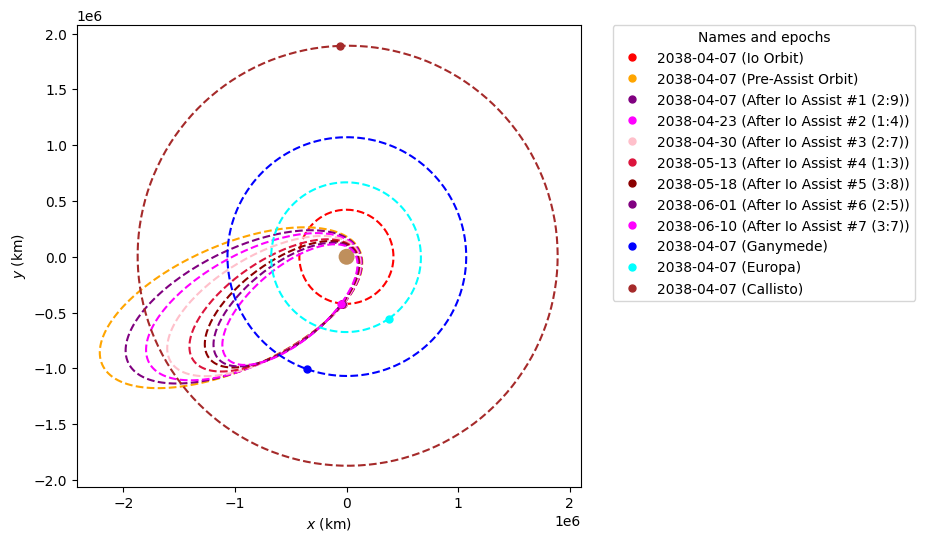

In [25]:
## Setup Io Resonance - Multiple Flybys
# Perform multiple resonant gravity assists with Io

if 'spacecraft_at_io' in locals() and 'io_orb_encounter' in locals():
    # Configuration for Io resonant assists
    r_p_min_io = 5 * u.km
    r_p_max_io = 2000 * u.km
    num_io_assists = 10  # Number of Io gravity assists to perform
    
    # Storage for Io results
    io_orbits_list = []
    io_resonances_list = []
    io_rp_list = []
    io_dv_list = []
    io_encounter_dates = [io_date]
    
    # Current state
    io_current_orbit = spacecraft_at_io
    io_current_date = io_date
    
    # Loop through Io gravity assists
    for io_assist_num in range(1, num_io_assists + 1):
        print("=" * 60)
        print(f"IO ENCOUNTER #{io_assist_num}")
        print("=" * 60)
        
        # Get Io's position at this encounter
        io_orb_current = placeholder_io_orbit.propagate(io_current_date)
        
        # Search for resonant orbit
        io_test_orbit, io_test_resonance, io_test_rp = search_for_resonant_slingshot(
            io_orb_current,
            Io,
            io_current_orbit.rv()[1],
            r_p_min_io,
            r_p_max_io,
            num_samples=500,
            max_resonance_ratio=10
        )
        
        if io_test_orbit is None:
            print(f"No resonant orbit found for Io encounter #{io_assist_num}")
            break
        
        # Calculate required period for exact resonance
        io_required_resonance_time = (io_test_resonance[1] / io_test_resonance[0]) * io_orb_current.period
        io_dif = io_test_orbit.period - io_required_resonance_time
        
        print(f"\n=== Io Encounter #{io_assist_num} Results ===")
        print(f"Resonance found: {io_test_resonance[0]}:{io_test_resonance[1]}")
        print(f"Spacecraft does {io_test_resonance[0]} orbits while Io does {io_test_resonance[1]}")
        print(f"Post-assist orbit period: {io_test_orbit.period.to(u.day):.2f}, should be {io_required_resonance_time.to(u.day):.2f}")
        print(f"Flyby periapsis altitude: {(io_test_rp - Io.R).to(u.km):.0f}")
        print(f"Eccentricity: {io_test_orbit.ecc:.3f}")
        
        # Apply delta-v correction to achieve exact resonance
        io_norm_vel_vec = io_test_orbit.rv()[1] / np.linalg.norm(io_test_orbit.rv()[1])
        io_total_dv = 0 * u.km/u.s
        io_dv_adjust = 0.001 * u.km/u.s
        
        if io_dif < 0:
            # Need to accelerate
            orbit_is_accurate = False
            while not orbit_is_accurate:
                io_total_dv += io_dv_adjust
                delta_v = io_dv_adjust
                burn = delta_v * io_norm_vel_vec
                maneuver = Maneuver((0*u.s, burn))
                io_test_orbit = io_test_orbit.apply_maneuver(maneuver)
                io_dif = io_test_orbit.period - io_required_resonance_time
                if io_dif >= 0:
                    orbit_is_accurate = True
        
        if io_dif > 0:
            # Need to decelerate
            orbit_is_accurate = False
            while not orbit_is_accurate:
                io_total_dv += io_dv_adjust
                delta_v = io_dv_adjust
                burn = -delta_v * io_norm_vel_vec
                maneuver = Maneuver((0*u.s, burn))
                io_test_orbit = io_test_orbit.apply_maneuver(maneuver)
                io_dif = io_test_orbit.period - io_required_resonance_time
                if io_dif <= 0:
                    orbit_is_accurate = True
        
        print(f"Total delta-v to adjust orbit: {io_total_dv.to(u.m/u.s):.2f}")
        
        # Store results
        io_orbits_list.append(io_test_orbit)
        io_resonances_list.append(io_test_resonance)
        io_rp_list.append(io_test_rp)
        io_dv_list.append(io_total_dv)
        
        # Calculate time to next encounter
        io_time_to_return = io_test_resonance[0] * io_test_orbit.period
        print(f"\nTime until next Io encounter: {io_time_to_return.to(u.day):.2f}")
        
        # Update state for next iteration
        io_current_date = io_current_date + io_time_to_return
        io_current_orbit = io_test_orbit.propagate(io_time_to_return)
        io_encounter_dates.append(io_current_date)
    
    # Print Io summary
    if len(io_orbits_list) > 0:
        print("\n" + "=" * 60)
        print("IO MISSION SUMMARY")
        print("=" * 60)
        
        # Visualize all Io orbits
        plotter = StaticOrbitPlotter(plane=Planes.EARTH_ECLIPTIC)
        plotter.plot(placeholder_io_orbit.propagate(io_date), label="Io Orbit", color="red")
        plotter.plot(spacecraft_at_io, label="Pre-Assist Orbit", color="orange")
        
        io_colors = ["purple", "magenta", "pink", "crimson", "darkred"]
        for i, io_orbit in enumerate(io_orbits_list):
            color = io_colors[i % len(io_colors)]
            plotter.plot(io_orbit, label=f"After Io Assist #{i+1} ({io_resonances_list[i][0]}:{io_resonances_list[i][1]})", color=color)
        
        # Show other moons for reference
        ganymede_ref = placeholder_ganymede_orbit.propagate(io_date)
        europa_ref = placeholder_europa_orbit.propagate(io_date)
        plotter.plot(ganymede_ref, label="Ganymede", color="blue")
        plotter.plot(europa_ref, label="Europa", color="cyan")
        plotter.plot(callisto_ref, label="Callisto", color="brown")
        
        # Print statistics
        io_total_dv = sum(io_dv_list)
        io_total_time = sum([(io_resonances_list[i][0] * io_orbits_list[i].period) for i in range(len(io_orbits_list))])
        
        print(f"\nCompleted {len(io_orbits_list)} Io gravity assists")
        print(f"Total ΔV for Io resonance corrections: {io_total_dv.to(u.m/u.s):.2f}")
        print(f"Total Io mission time: {io_total_time.to(u.day):.2f}")
        
        print(f"\nIo encounter dates:")
        for i, date in enumerate(io_encounter_dates[:-1]):
            print(f"  Io Encounter #{i+1}: {date}")
        print(f"  Next Io encounter (#{len(io_encounter_dates)}): {io_encounter_dates[-1]}")
        
        print(f"\nIo resonances achieved:")
        for i, res in enumerate(io_resonances_list):
            print(f"  Assist #{i+1}: {res[0]}:{res[1]} (period = {io_orbits_list[i].period.to(u.day):.2f})")
        
        print(f"\nIo periapsis altitudes:")
        for i, rp in enumerate(io_rp_list):
            altitude = (rp - Io.R).to(u.km)
            print(f"  Assist #{i+1}: {altitude:.0f} ({rp.to(u.km):.0f} from center)")
        
        print(f"\nIo delta-v per assist:")
        for i, dv in enumerate(io_dv_list):
            print(f"  Assist #{i+1}: {dv.to(u.m/u.s):.2f}")
        
        # Complete mission summary
        print("\n" + "=" * 80)
        print("COMPLETE MISSION SUMMARY")
        print("=" * 80)
        print(f"\nGanymede resonant assists: {len(orbits_list)}")
        print(f"Callisto gravity assist: 1")
        print(f"Io resonant assists: {len(io_orbits_list)}")
        print(f"\nTotal mission timeline:")
        print(f"  Jupiter arrival: {first_assist_date.iso}")
        print(f"  Last Ganymede encounter: {encounter_dates[-1].iso}")
        print(f"  Callisto encounter: {callisto_date.iso}")
        print(f"  First Io encounter: {io_date.iso}")
        print(f"  Last Io encounter: {io_encounter_dates[-2].iso}")
        print(f"  Next Io encounter: {io_encounter_dates[-1].iso}")
        print(f"\nTotal mission duration: {(io_encounter_dates[-2] - first_assist_date).to(u.day):.1f}")
        
        ganymede_total_dv = sum(dv_list)
        print(f"\nTotal ΔV budget:")
        print(f"  Ganymede corrections: {ganymede_total_dv.to(u.m/u.s):.2f}")
        print(f"  Io corrections: {io_total_dv.to(u.m/u.s):.2f}")
        print(f"  Combined total: {(ganymede_total_dv + io_total_dv).to(u.m/u.s):.2f}")
    else:
        print("No Io resonant orbits found - try adjusting periapsis bounds or tolerance")
else:
    print("Need to run Io transfer first")

SEARCHING FOR EUROPA TRANSFER
Trying orbit #1 starting at 2038-06-10 19:32:39.611
Getting ephems from 2038-06-10 19:32:39.611.
Orbit #1: Found transfer with ΔV = 273.81 m / s
Trying orbit #2 starting at 2038-06-14 22:40:29.299
Getting ephems from 2038-06-10 19:32:39.611.
Trying orbit #3 starting at 2038-06-19 01:48:18.986
Getting ephems from 2038-06-10 19:32:39.611.
Trying orbit #4 starting at 2038-06-23 04:56:08.674
Getting ephems from 2038-06-10 19:32:39.611.
Trying orbit #5 starting at 2038-06-27 08:03:58.361
Getting ephems from 2038-06-10 19:32:39.611.
Trying orbit #6 starting at 2038-07-01 11:11:48.048
Getting ephems from 2038-06-10 19:32:39.611.
Trying orbit #7 starting at 2038-07-05 14:19:37.736
Getting ephems from 2038-06-10 19:32:39.611.
Trying orbit #8 starting at 2038-07-09 17:27:27.423
Getting ephems from 2038-06-10 19:32:39.611.
Trying orbit #9 starting at 2038-07-13 20:35:17.111
Getting ephems from 2038-06-10 19:32:39.611.
Trying orbit #10 starting at 2038-07-17 23:43:06.

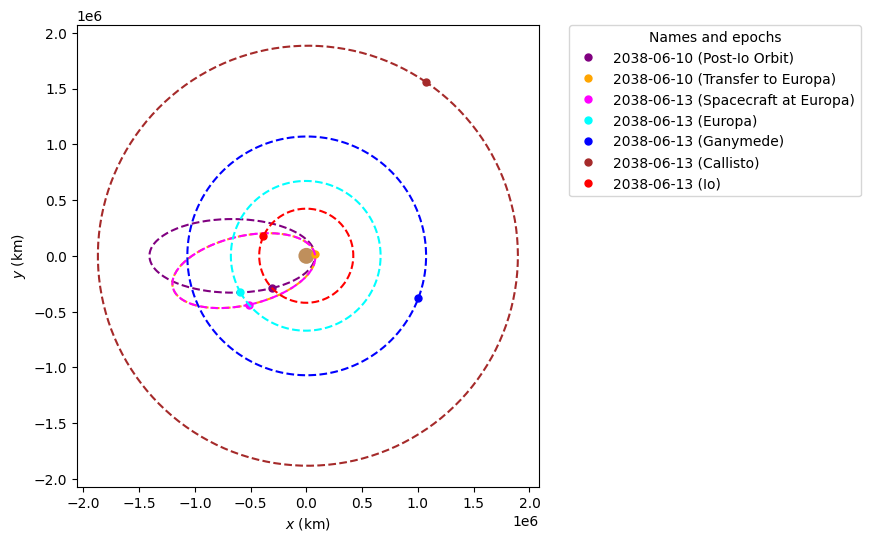

In [29]:
## Transfer to Europa from Io
# After Io gravity assists, find burn to reach Europa

if len(io_orbits_list) > 0:
    # Use the last Io gravity assist orbit
    post_io_orbit = io_orbits_list[-1]
    last_io_date = io_encounter_dates[-2]
    
    # Match plane with Europa for easier transfer
    coplanar_post_io = match_orbit_plane(post_io_orbit, placeholder_europa_orbit)
    
    # Search across multiple orbits to find best Europa transfer
    best_europa_dv = np.inf * u.m/u.s
    best_europa_transfer = None
    best_europa_date = None
    best_europa_burn = None
    best_orbit_number = None
    
    print("=" * 60)
    print("SEARCHING FOR EUROPA TRANSFER")
    print("=" * 60)
    
    for orbit_num in range(1, 16):  # Search up to 15 orbits
        # Calculate when this orbit's periapsis occurs
        time_offset = (orbit_num - 1) * post_io_orbit.period
        search_start = last_io_date + time_offset
        
        # Propagate to this orbit's periapsis
        t_to_pe = post_io_orbit.period - post_io_orbit.t_p
        periapsis_time = search_start + t_to_pe
        print(f"Trying orbit #{orbit_num} starting at {periapsis_time.iso}")
        # Search for transfer during this orbit
        try:
            europa_dv, europa_transfer_orb, europa_date, europa_burn, europa_target = get_single_burn_elliptical_hohmann_test(
                Jupiter,
                Europa,
                coplanar_post_io,
                search_start - last_io_date,
                search_start - last_io_date + post_io_orbit.period,
                tof_step=0.01*u.day
            )
            
            if europa_dv < best_europa_dv:
                best_europa_dv = europa_dv
                best_europa_transfer = europa_transfer_orb
                best_europa_date = europa_date
                best_europa_burn = europa_burn
                best_orbit_number = orbit_num
                print(f"Orbit #{orbit_num}: Found transfer with ΔV = {europa_dv.to(u.m/u.s):.2f}")
        except:
            continue
    
    if best_europa_transfer is not None:
        # Propagate spacecraft to Europa encounter
        spacecraft_at_europa = best_europa_transfer.propagate(best_europa_date)
        europa_orb_encounter = placeholder_europa_orbit.propagate(best_europa_date)
        
        # Calculate arrival V-infinity
        rel_vel_europa = spacecraft_at_europa.rv()[1] - europa_orb_encounter.rv()[1]
        v_inf_europa = np.linalg.norm(rel_vel_europa)
        
        print("\n" + "=" * 60)
        print("EUROPA TRANSFER RESULTS")
        print("=" * 60)
        print(f"Best transfer found on orbit #{best_orbit_number}")
        print(f"Transfer ΔV: {best_europa_dv.to(u.m/u.s):.2f}")
        print(f"Transfer burn date: {(best_europa_date - best_orbit_number * post_io_orbit.period).iso}")
        print(f"Europa encounter date: {best_europa_date.iso}")
        print(f"Time from last Io encounter: {(best_europa_date - last_io_date).to(u.day):.1f}")
        print(f"\nArrival V∞ at Europa: {v_inf_europa.to(u.km/u.s):.3f}")
        
        print(f"\nSpacecraft state at Europa:")
        print(f"  Period: {spacecraft_at_europa.period.to(u.day):.2f}")
        print(f"  Eccentricity: {spacecraft_at_europa.ecc:.3f}")
        print(f"  Periapsis: {spacecraft_at_europa.r_p.to(u.km):.0f}")
        print(f"  Apoapsis: {spacecraft_at_europa.r_a.to(u.km):.0f}")
        
        # Visualize
        plotter = StaticOrbitPlotter(plane=Planes.EARTH_ECLIPTIC)
        plotter.plot(post_io_orbit, label="Post-Io Orbit", color="purple")
        plotter.plot(best_europa_transfer, label="Transfer to Europa", color="orange")
        plotter.plot(spacecraft_at_europa, label="Spacecraft at Europa", color="magenta")
        plotter.plot(europa_orb_encounter, label="Europa", color="cyan")
        
        # Show other moons for reference
        plotter.plot(placeholder_ganymede_orbit.propagate(best_europa_date), label="Ganymede", color="blue")
        plotter.plot(placeholder_callisto_orbit.propagate(best_europa_date), label="Callisto", color="brown")
        plotter.plot(placeholder_io_orbit.propagate(best_europa_date), label="Io", color="red")
    else:
        print("No Europa transfer found in 15 orbits")
else:
    print("Need to complete Io resonance sequence")